Model X에서 실행했던 정규화 layer를 imageoperatio에서 사용한 거랑 성능 비교

In [13]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten,Dropout, experimental
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

import pandas as pd 
import os
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten
from keras.utils import to_categorical

from keras.models import Sequential,load_model

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
np.random.seed(1)


train_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split = 0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2)

train_generator = train_datagen.flow_from_directory(
        './image_15000/train',
        target_size = (300,300),
        batch_size=128,
        #color_mode ='rgb',
        classes = ['food','interior', 'exterior'],
        shuffle =True,
        seed = 42,
        class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        './image_15000/test',
        classes = ['food','interior', 'exterior'],
        target_size=(300,300),
        batch_size=32,
#         color_mode ='rgb',
        shuffle =True,
        seed = 42,
        class_mode='categorical')


def plot_loss_curve(history):
    
    plt.figure(figsize = (5,3))
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])

    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['train','test'], loc = 'upper right')
    plt.show

    
def plot_accuracy_curve(history):

    plt.figure(figsize = (5,3))
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])

    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['train','test'], loc = 'upper right')
    plt.show

Found 13930 images belonging to 3 classes.
Found 3929 images belonging to 3 classes.


정규화 O

In [18]:
model = Sequential([
Input(shape=(300,300,3), name='input_layer'),
experimental.preprocessing.Rescaling(1./255),
Conv2D(32,(3,3), activation='relu',name='Conv_layer1'),
MaxPooling2D(pool_size=(2,2),name='Pooling_layer2'),
Conv2D(32,(3,3), activation='relu',name='Conv_layer3'),
MaxPooling2D(pool_size=(2,2),name='Pooling_layer4'),
Conv2D(32,(3,3), activation='relu',name='Conv_layer5'),
MaxPooling2D(pool_size=(2,2),name='Pooling_layer6'),
Dropout(0.5),
Conv2D(32,(3,3), activation='relu',name='Conv_layer7'),
Conv2D(32,(3,3), activation='relu',name='Conv_layer8'),
MaxPooling2D(pool_size=(2,2),name='Pooling_layer9'),
Flatten(),
Dense(10, activation='relu',name='FC_layer10'),
Dense(3, activation='softmax', name='output_layer')
])


# 3. 모델 학습과정 설정 및 요약
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# 4. 모델 학습
history1 = model.fit_generator(
    train_generator,
    steps_per_epoch=3,
    epochs=5,
    validation_data=test_generator,
    validation_steps=3)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 300, 300, 3)       0         
_________________________________________________________________
Conv_layer1 (Conv2D)         (None, 298, 298, 32)      896       
_________________________________________________________________
Pooling_layer2 (MaxPooling2D (None, 149, 149, 32)      0         
_________________________________________________________________
Conv_layer3 (Conv2D)         (None, 147, 147, 32)      9248      
_________________________________________________________________
Pooling_layer4 (MaxPooling2D (None, 73, 73, 32)        0         
_________________________________________________________________
Conv_layer5 (Conv2D)         (None, 71, 71, 32)        9248      
_________________________________________________________________
Pooling_layer6 (MaxPooling2D (None, 35, 35, 32)       

train accuracy =0.39322999119758606 , validation accuracy =0.34375
train loss =1.09633 ,     validation loss =1.09748
-- Evaluate --
acc: 30.00%
-- Predict --
{'food': 0, 'interior': 1, 'exterior': 2}


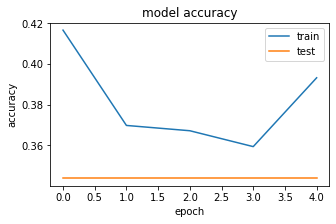

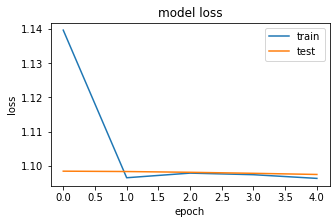

In [19]:
plot_accuracy_curve(history1.history)

print('train accuracy ={} , validation accuracy ={}' .format(
                                                            round(history1.history['acc'][-1],5), 
                                                            round(history1.history['val_acc'][-1],5) ))
plot_loss_curve(history1.history)
print('train loss ={} ,     validation loss ={}' .format(
                                                        round(history1.history['loss'][-1],5), 
                                                        round(history1.history['val_loss'][-1],5) ))

print("-- Evaluate --")
scores = model.evaluate_generator(test_generator, steps=5)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

print("-- Predict --")
output = model.predict_generator(test_generator, steps=5)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(test_generator.class_indices)
#print(output)

정규화 X

In [16]:
model = Sequential([
Input(shape=(300,300,3), name='input_layer'),
# experimental.preprocessing.Rescaling(1./255),
Conv2D(32,(3,3), activation='relu',name='Conv_layer1'),
MaxPooling2D(pool_size=(2,2),name='Pooling_layer2'),
Conv2D(32,(3,3), activation='relu',name='Conv_layer3'),
MaxPooling2D(pool_size=(2,2),name='Pooling_layer4'),
Conv2D(32,(3,3), activation='relu',name='Conv_layer5'),
MaxPooling2D(pool_size=(2,2),name='Pooling_layer6'),
Dropout(0.5),
Conv2D(32,(3,3), activation='relu',name='Conv_layer7'),
Conv2D(32,(3,3), activation='relu',name='Conv_layer8'),
MaxPooling2D(pool_size=(2,2),name='Pooling_layer9'),
Flatten(),
Dense(10, activation='relu',name='FC_layer10'),
Dense(3, activation='softmax', name='output_layer')
])


# 3. 모델 학습과정 설정 및 요약
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# 4. 모델 학습
history2= model.fit_generator(
    train_generator,
    steps_per_epoch=3,
    epochs=5,
    validation_data=test_generator,
    validation_steps=3)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_layer1 (Conv2D)         (None, 298, 298, 32)      896       
_________________________________________________________________
Pooling_layer2 (MaxPooling2D (None, 149, 149, 32)      0         
_________________________________________________________________
Conv_layer3 (Conv2D)         (None, 147, 147, 32)      9248      
_________________________________________________________________
Pooling_layer4 (MaxPooling2D (None, 73, 73, 32)        0         
_________________________________________________________________
Conv_layer5 (Conv2D)         (None, 71, 71, 32)        9248      
_________________________________________________________________
Pooling_layer6 (MaxPooling2D (None, 35, 35, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 35, 35, 32)       

C:\ProgramData\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\ProgramData\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


3/3 [==============================] - 12s 4s/step - batch: 1.0000 - size: 128.0000 - loss: 9.1686 - acc: 0.3776 - val_loss: 1.0826 - val_acc: 0.3438
Epoch 2/5
3/3 [==============================] - 13s 4s/step - batch: 1.0000 - size: 128.0000 - loss: 10.4096 - acc: 0.3542 - val_loss: 1.0845 - val_acc: 0.3438
Epoch 3/5
3/3 [==============================] - 12s 4s/step - batch: 1.0000 - size: 128.0000 - loss: 9.3183 - acc: 0.4219 - val_loss: 1.0861 - val_acc: 0.3438
Epoch 4/5
3/3 [==============================] - 13s 4s/step - batch: 1.0000 - size: 128.0000 - loss: 10.2837 - acc: 0.3620 - val_loss: 1.0878 - val_acc: 0.3438
Epoch 5/5
3/3 [==============================] - 14s 5s/step - batch: 1.0000 - size: 128.0000 - loss: 9.8220 - acc: 0.3906 - val_loss: 1.0899 - val_acc: 0.3438


train accuracy =0.39061999320983887 , validation accuracy =0.34375
train loss =9.82196 ,     validation loss =1.08989
-- Evaluate --


C:\ProgramData\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\ProgramData\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\ProgramData\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\ProgramData\Anaconda3\lib\site-packages\keras_preprocessing

acc: 30.00%
-- Predict --
{'food': 0, 'interior': 1, 'exterior': 2}


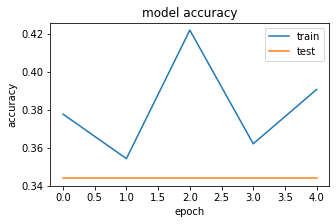

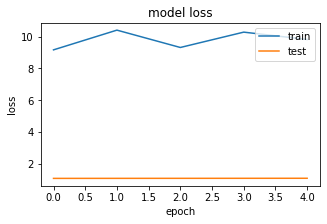

In [17]:
plot_accuracy_curve(history2.history)

print('train accuracy ={} , validation accuracy ={}' .format(
                                                            round(history2.history['acc'][-1],5), 
                                                            round(history2.history['val_acc'][-1],5) ))
plot_loss_curve(history2.history)
print('train loss ={} ,     validation loss ={}' .format(
                                                        round(history2.history['loss'][-1],5), 
                                                        round(history2.history['val_loss'][-1],5) ))


print("-- Evaluate --")
scores = model.evaluate_generator(test_generator, steps=5)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

print("-- Predict --")
output = model.predict_generator(test_generator, steps=5)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(test_generator.class_indices)
#print(output)